In [105]:
import glob
import numpy as np
import seaborn as sns
import collections
import matplotlib.pyplot as plt
from utils import *

%matplotlib inline

In [106]:
# Utils

PDB_TO_UNIPROT_TABLE_PATH = "/scratch/PI/rondror/akma327/DynamicNetworks/data/crystal-analysis/simulation-analysis/gpcrdb-freq-config/GPCR_PDB_List.txt"
GPCRDB_TABLE_PATH="/scratch/PI/rondror/akma327/DynamicNetworks/data/crystal-analysis/simulation-analysis/gpcrdb-freq-config/All_species_gpcrdb_numbers_strOnly.txt"


# Rename amino acids to common name
def fixAminoAcidNames(key):
	key = key.replace("HSD", "HIS")
	key = key.replace("HSE", "HIS")
	key = key.replace("HSP", "HIS")
	key = key.replace("HIE", "HIS")
	key = key.replace("HIP", "HIS")
	key = key.replace("HID", "HIS")
	key = key.replace("GLH", "GLU")
	key = key.replace("ASH", "ASP")
	key = key.replace("CYP", "CYS")
	key = key.replace("CYX", "CYS")
	return key

def getGPCRDB(res, GPCRDB_DICT):
	res = fixAminoAcidNames(res)
	if(res == "LIG"): return "LIGxLIG"
	if(res not in GPCRDB_DICT):
# 		print(res + " not found.")
		return "None"
	return GPCRDB_DICT[res]

# Retrieve Uniprot Code for the PDB_CODE from pdb_to_uniprot_table_path
def getUniprotCode(PDB_CODE):
	f = open(PDB_TO_UNIPROT_TABLE_PATH, 'r')
	for line in f:
		if(line == "\n"): continue 
		l_info = line.split("\t")
		uniprot_code, pdb = l_info[0].strip(), l_info[2].strip()
		if(PDB_CODE.upper() == pdb.upper()): return uniprot_code.upper()
	print("PDB_CODE Not Found in PDB To Uniprot Table")
	exit(1)


# Given uniprot code reads through GPCRDB_TABLE_PATH to generate the amino acid
# to gpcrdb number table. 
# Output {"ASP112": "1x50", "ARG116":"2x45"}
def genGpcrdbDict(UNIPROT_CODE):
	GPCRDB_DICT = {}
	f = open(GPCRDB_TABLE_PATH, 'r')
	for line in f: 
		l_info = line.split("\t")
		uniprot, resnum, resname, gpcrdb = l_info[0].strip(), l_info[1].strip(), l_info[2].strip(), l_info[4].strip()
		if(uniprot.upper() == UNIPROT_CODE.upper()):
			key = resname.upper() + resnum 
			GPCRDB_DICT[key] = gpcrdb
	return GPCRDB_DICT


# Generates the residue to gpcrdb table for given pdb
def genResidueToGpcrdbTable(PDB_CODE):
	UNIPROT_CODE = getUniprotCode(PDB_CODE)
	GPCRDB_DICT = genGpcrdbDict(UNIPROT_CODE)
	return GPCRDB_DICT




def get_sorted_positions(positions):
	aa_freq = position_to_conserve_freq()
	pos_to_aa_freq = collections.Counter()
	for pos in positions:
		freq = aa_freq[pos]
		pos_to_aa_freq[pos] = freq 

	sorted_pos = [pos for pos, freq in pos_to_aa_freq.most_common()]
	return sorted_pos

In [107]:
def order(g1, g2):
    if(g1 <= g2): return (g1, g2)
    else: return (g2, g1)

def get_wet_spots(pdb, fp):
    """
        Take in residue water interaction file and calculate the position of 
        wet spots. 
    """
    
    wet_spots = set() # wet spots
    GPCRDB_DICT = genResidueToGpcrdbTable(pdb)
    f = open(fp, 'r')
    for line in f:
        atom_pair = line.strip().split("@")[0].split(" -- ")
        res1, res2 = atom_pair[0].split("-")[0], atom_pair[1].split("-")[0]
        gpcrdb1, gpcrdb2 = getGPCRDB(res1, GPCRDB_DICT), getGPCRDB(res2, GPCRDB_DICT)
        if(gpcrdb1 == 'None' or gpcrdb2 == 'None'): continue 
        gpcrdb1, gpcrdb2 = order(gpcrdb1, gpcrdb2)
        wet_spots.add((gpcrdb1, gpcrdb2))

    return list(wet_spots)


def gen_bit_matrix(pdb_to_wetspots):
    """
        Generate the position pair to pdb matrix
    """
    union_pos = set()
    for pos in pdb_to_wetspots:
        union_pos |= set(pdb_to_wetspots[pos])
    
    sorted_union_pos = sorted(list(union_pos))
    pdbs = sorted(pdb_to_wetspots.keys())
    
    ### Generate bit matrix 
    bit_mat = np.zeros((len(sorted_union_pos), len(pdbs)))
    for j, pdb in enumerate(pdbs):
        for i, pos in enumerate(sorted_union_pos):
            if(pos in pdb_to_wetspots[pdb]):
                bit_mat[i][j] = 1
    
    sorted_labels = [res1 + ":" + res2 for res1, res2 in sorted_union_pos]
    ### Plot heatmap
    ax = sns.heatmap(bit_mat, cmap="Reds")
    ax.set_xticklabels(pdbs, rotation=90)
#     row_labels = [t for t in reversed(sorted_labels)]
    row_labels = ["" for t in sorted_labels]
    ax.set_yticklabels(row_labels, rotation=90)
    plt.ylabel("Residue Pairs")
    plt.title("High Resolution Class A GPCRs Water Bridges")
    plt.show()
    
    return bit_mat, sorted_labels, pdbs

def genBitMap(INPUT_DIR):
    pdb_to_wetspots = {}
    files = sorted(glob.glob(INPUT_DIR + "/*"))
    for i, fp in enumerate(files):
        pdb = fp.strip().split("/")[-1].strip(".txt")
        wet_spots = get_wet_spots(pdb, fp)
        pdb_to_wetspots[pdb] = wet_spots
    return gen_bit_matrix(pdb_to_wetspots)

In [108]:
def write_output(OUTPUT_FILE, bit_mat, row_labels, col_labels):
    """
        Write out the bit matrix
    """
    f = open(OUTPUT_FILE, 'w')
    header = "GPCRDB1:GPCRDB2"
    for col in col_labels:
        header += "\t" + col
    f.write(header + "\n")
    
    ### Write rows 
    for i, row in enumerate(row_labels):
        rinfo = row
        for bit in bit_mat[i]:
            rinfo += "\t" + str(int(bit))
        f.write(rinfo + "\n")


In [109]:
INPUT_DIR_70D="/scratch/PI/rondror/akma327/DynamicNetworks/data/crystal-analysis/residue-water-conservation/111916/high_res_crystal_water_bridge_70D"

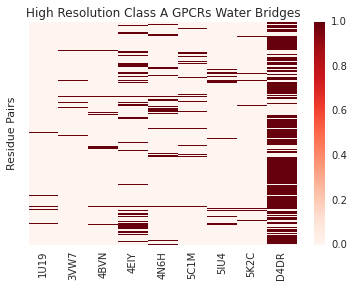

In [110]:
bit_mat, row_labels, col_labels = genBitMap(INPUT_DIR_70D)

In [111]:
OUTPUT_FILE="/scratch/PI/rondror/akma327/DynamicNetworks/data/crystal-analysis/residue-water-conservation/111916/tables/high_res_crystal_water_bridges_70D.txt"
write_output(OUTPUT_FILE, bit_mat, row_labels, col_labels)

In [112]:
INPUT_DIR_NOANG = "/scratch/PI/rondror/akma327/DynamicNetworks/data/crystal-analysis/residue-water-conservation/111916/high_res_crystal_water_bridge_noang"

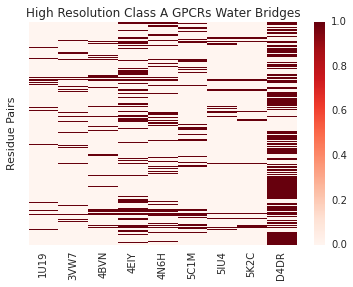

In [113]:
bit_mat, row_labels, col_labels = genBitMap(INPUT_DIR_NOANG)

In [114]:
OUTPUT_FILE="/scratch/PI/rondror/akma327/DynamicNetworks/data/crystal-analysis/residue-water-conservation/111916/tables/high_res_crystal_water_bridges_noang.txt"
write_output(OUTPUT_FILE, bit_mat, row_labels, col_labels)